In [6]:

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

import seaborn as sns
from datetime import datetime
from pathlib import Path


# Paths
DATA_DAILY = Path("data/daily")
AVERAGE_OUTPUT = Path("data/averages")
OUT_WEEKLY = Path("output/weekly")
OUT_DAILY = Path("output/daily")
OUT_TOP20 = Path("output/top20")
OUTPUT_RECOMENDATIONS = Path("output/recommendations")
ML_FOLDER = Path("ml")

for p in (AVERAGE_OUTPUT, OUT_WEEKLY, OUT_DAILY, ML_FOLDER, OUT_TOP20, OUTPUT_RECOMENDATIONS):
    p.mkdir(parents=True, exist_ok=True)

# Load all hot_stocks CSVs
files = sorted([f for f in DATA_DAILY.glob("hot_stocks_*.csv")])
if not files:
    raise ValueError("⚠ No daily hot stocks files found in data/daily/. Cannot compute averages.")

all_days = []
for f in files:
    date = f.stem.split("_")[-1]  # get YYYYMMDDhhmmss
    df = pd.read_csv(f)
    df["date"] = pd.to_datetime(date, format="%Y%m%d%H%M%S")
    all_days.append(df)

full_df = pd.concat(all_days, ignore_index=True)

# Metrics to average
metrics = [
    "HotScore",
    "regularMarketChangePercent",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore"
]
metrics = [m for m in metrics if m in full_df.columns]


In [7]:

# Compute averages
avg_df = full_df.groupby("symbol")[metrics].mean().sort_values("HotScore", ascending=False)
avg_csv = AVERAGE_OUTPUT / "average_hot_scores.csv"
avg_df.to_csv(avg_csv)
print("✅ Saved average results:", avg_csv)

# Compute persistent appearances
appearances = full_df["symbol"].value_counts()
persistent_df = pd.DataFrame({
    "Appearances": appearances,
    "AvgHotScore": avg_df["HotScore"]
}).sort_values(["Appearances", "AvgHotScore"], ascending=False)
persistent_csv = AVERAGE_OUTPUT / "persistent_hot_stocks.csv"
persistent_df.to_csv(persistent_csv)
print("✅ Saved persistent list:", persistent_csv)


✅ Saved average results: data\averages\average_hot_scores.csv
✅ Saved persistent list: data\averages\persistent_hot_stocks.csv


In [8]:

# Visuals
date_str = datetime.now().strftime("%Y%m%d%H%M%S") 
top20_avg = avg_df.head(20)
top20_file = OUT_TOP20 / f"top20_avg_{date_str}.png"
plt.figure(figsize=(12,6))
plt.bar(top20_avg.index, top20_avg["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 20 Consistently Hot Stocks")
plt.ylabel("HotScore")
plt.tight_layout()
plt.savefig(top20_file)
plt.close()
print("Saved:", top20_file)



Saved: output\top20\top20_avg_20251126104230.png


In [9]:

if "regularMarketChangePercent" in avg_df.columns:
    top20_move = avg_df.sort_values("regularMarketChangePercent", ascending=False).head(20)
    move_file = OUT_TOP20 / f"top20_movers_{date_str}.png"
    plt.figure(figsize=(12,6))
    plt.bar(top20_move.index, top20_move["regularMarketChangePercent"])
    plt.xticks(rotation=90)
    plt.title("Top 20 Movers (Avg Daily % Change)")
    plt.ylabel("Avg % Change")
    plt.tight_layout()
    plt.savefig(move_file)
    plt.close()
    print("Saved:", move_file)

# Basic HTML report
html_file = OUT_DAILY / f"weekly_report_{date_str}.html"
html_parts = [
    f"<h1>Weekly Hot Stocks — {date_str}</h1>",
    "<h2>Top 20 Average HotScore</h2>",
    top20_avg.to_html(index=True, classes='table table-sm', border=0),
    f'<img src="{top20_file.name}" alt="Top20 Average HotScore" style="max-width:100%;">'
]
if "move_file" in locals():
    html_parts.append("<h2>Top 20 Movers</h2>")
    html_parts.append(f'<img src="{move_file.name}" alt="Top20 Movers" style="max-width:100%;">')

with open(html_file, "w", encoding="utf-8") as fh:
    fh.write("<html><head><meta charset='utf-8'><title>Weekly Hot Stocks</title></head><body>")
    fh.write("\n".join(html_parts))
    fh.write("</body></html>")
print("Saved:", html_file)

# Metadata for dashboard
meta = {
    "date": date_str,
    "files": {
        "average_csv": str(avg_csv),
        "persistent_csv": str(persistent_csv),
        "top20_avg_png": str(top20_file),
        "top20_movers_png": str(move_file) if "move_file" in locals() else None,
        "html_report": str(html_file)
    }
}
meta_file = AVERAGE_OUTPUT / f"metadata_weekly_{date_str}.json"
with open(meta_file, "w", encoding="utf-8") as fh:
    json.dump(meta, fh, indent=2)
print("Saved:", meta_file)

Saved: output\top20\top20_movers_20251126104230.png
Saved: output\daily\weekly_report_20251126104230.html
Saved: data\averages\metadata_weekly_20251126104230.json


C:\Users\a73s\AppData\Local\Temp\ipykernel_5324\1683505766.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="symbol", y="HotScore", data=top20_avg, palette="YlOrRd")


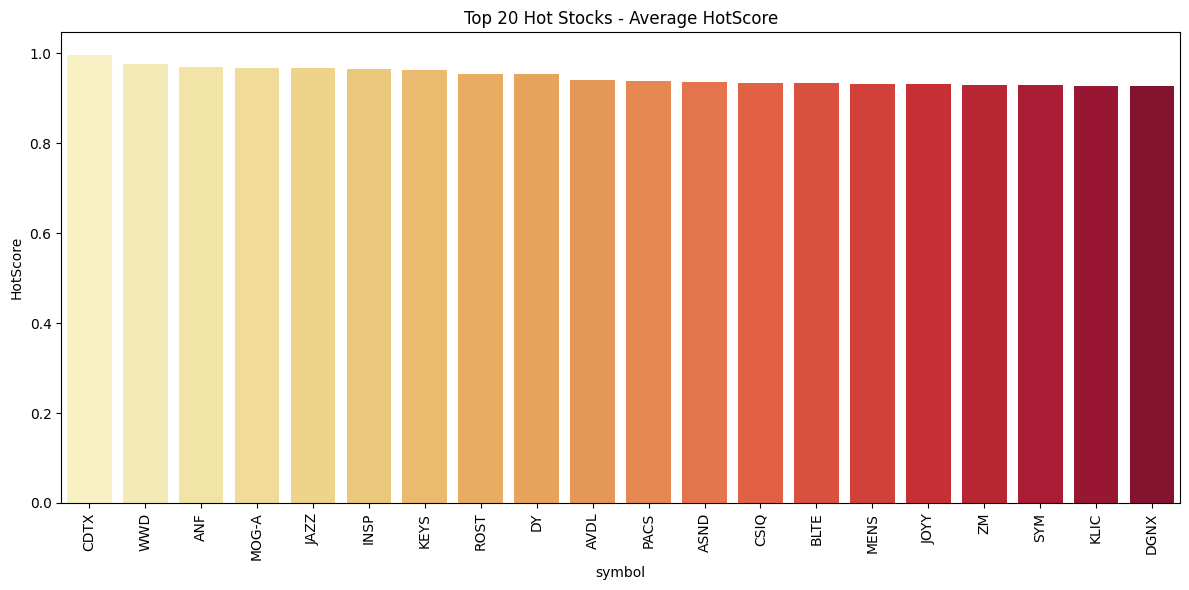

Saved chart to: output\recommendations\top20_avg_hotstocks_20251126104231.png


In [10]:

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# Bar chart
plt.figure(figsize=(12,6))
sns.barplot(x="symbol", y="HotScore", data=top20_avg, palette="YlOrRd")
plt.xticks(rotation=90)
plt.title("Top 20 Hot Stocks - Average HotScore")
plt.tight_layout()

# Save with timestamp
file_path = OUTPUT_RECOMENDATIONS / f"top20_avg_hotstocks_{timestamp}.png"
plt.savefig(file_path)
plt.show()

print("Saved chart to:", file_path)
